# Analysis of the historical price of a troy ounce of gold adjusted for inflation

## Setup

In [1]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from statsmodels.tsa.seasonal import STL

In [2]:
# Get gold price and US CPI dfs and set date (or year_month) as index
df_au = pd.read_csv("../data/AU.csv", index_col="date", parse_dates=True)
df_cpi = pd.read_csv("../data/US_CPI_M.csv", index_col="year_month", parse_dates=True)

In [3]:
# Append the CPI estimate for April of 2024 to the CPI df
df_cpi.loc[pd.to_datetime("2024-04")] = {"rate": 3.4}

In [4]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

## Adjustment of gold price for inflation (using 2023 prices)

In [5]:
# Make CPI rates decimal
df_cpi["rate"] = df_cpi["rate"] / 100

In [6]:
# Get cumulative product of rates until 2023 (which is the base year)
all_months = []
for month in range(1, 12 + 1):
    # Cumulative product of year over year CPI rate for each month number
    cumulative_product = np.cumprod((1 + df_cpi[:f"2023-{month:02}"]["rate"])[::-12])
    # Shift the cumulative product to align with the prior year
    cumulative_product = cumulative_product.shift(1).fillna(1)
    all_months.append(cumulative_product)

In [7]:
# Add cumulative CPI rates to the df
df_cpi["cumulative_rate"] = pd.concat(all_months)

In [8]:
# Get 2024 months cumulative rate by just inverting respective rate
df_cpi.loc[df_cpi.index.year == 2024, "cumulative_rate"] = 1 / (1 + df_cpi["rate"])

In [9]:
# Add the cumulative CPI rates to the gold price df (May values will have the same rate as April)
df_cpi_reindexed = df_cpi.reindex(df_au.index, method="ffill")
df_au["cpi_cumulative_rate"] = df_cpi_reindexed["cumulative_rate"]

In [10]:
# Adjust all prices to 2023 dollars
df_au["real_price"] = df_au["price"] * df_au["cpi_cumulative_rate"]

## Price of gold adjusted for inflation across time

In [11]:
# Get 1-year moving average
df_au["real_price_1y_ma"] = df_au["real_price"].rolling(window=252).mean()

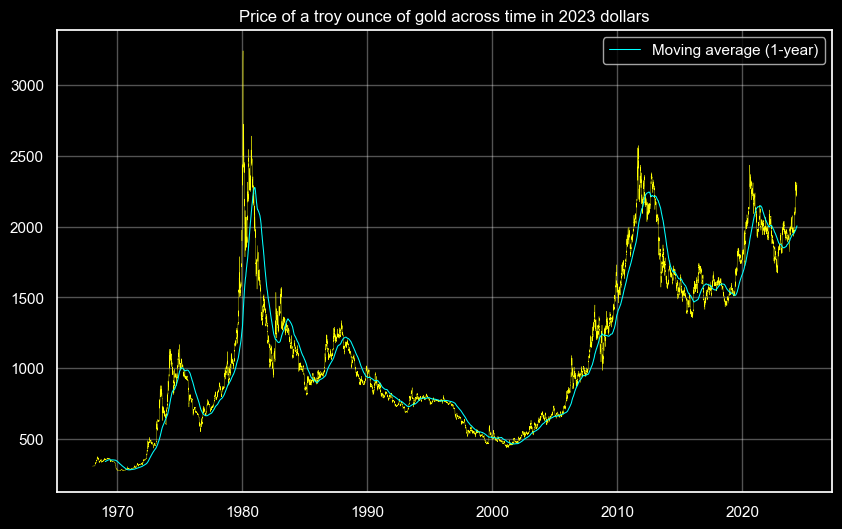

In [12]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_au, x=df_au.index, y="real_price", color="yellow", linewidth=0.25)
sns.lineplot(data=df_au, x=df_au.index, y="real_price_1y_ma", label="Moving average (1-year)", color="aqua", linewidth=0.75)

plt.title("Price of a troy ounce of gold across time in 2023 dollars")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("3.1_AU_real_price")

**Comparison of real price with nominal price**

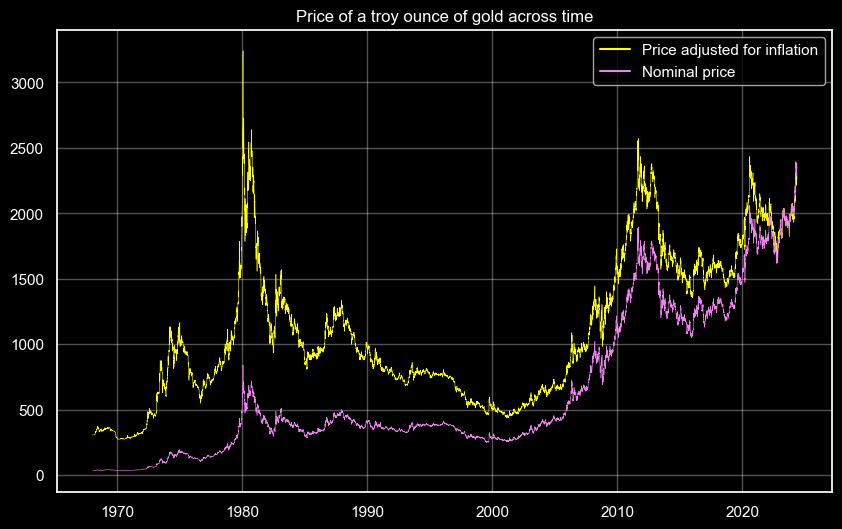

In [13]:
plt.figure(figsize=(10, 6))

real_color = "yellow"
nominal_color = "violet"

sns.lineplot(data=df_au, x=df_au.index, y="real_price", color=real_color, linewidth=0.4)
sns.lineplot(data=df_au, x=df_au.index, y="price", color=nominal_color, linewidth=0.4)

plt.title("Price of a troy ounce of gold across time")
plt.xlabel("")
plt.ylabel("")

# Manually create legend handles with a larger linewidth just to be able to see it
legend_handles = [Line2D([0], [0], color=real_color, lw=1.5, label="Price adjusted for inflation"),
                  Line2D([0], [0], color=nominal_color, lw=1.5, label="Nominal price")]
plt.legend(handles=legend_handles)

save_chart_as_png("3.1_AU_real_and_nominal_price")

In [14]:
# All-time high
ath_date = df_au["real_price"].idxmax()
df_au.loc[[ath_date], ["real_price"]]

,real_price
date,
1980-01-21,3241.649229


In [15]:
# All-time low
atl_date = df_au["real_price"].idxmin()
df_au.loc[[atl_date], ["real_price"]]

,real_price
date,
1970-01-16,275.268058


In [16]:
# Peaks
peaks, _ = signal.find_peaks(df_au["real_price"], distance=800)
df_au.iloc[peaks].nlargest(10, "real_price").sort_values("date")[["real_price"]].T

date,1974-12-30,1980-01-21,1983-04-18,1987-12-14,1993-08-02,2008-03-17,2011-09-05,2016-07-06,2020-08-07,2024-04-12
real_price,1167.289692,3241.649229,1362.979807,1336.365264,862.344435,1446.78518,2572.71987,1740.431995,2435.129922,2316.054159


In [17]:
# Valleys
valleys, _ = signal.find_peaks(-df_au["real_price"], distance=1000)
df_au.iloc[valleys].nsmallest(10, "real_price").sort_values("date")[["real_price"]].T

date,1970-01-16,1976-08-31,1981-03-05,1985-02-26,1993-01-15,1997-02-12,2001-02-16,2005-02-08,2009-01-22,2016-01-04
real_price,275.268058,551.202601,1558.633356,808.862264,686.979078,635.043835,439.28116,645.441397,1201.182931,1354.571489


In [18]:
# Real price appreciation since first entry
first_entry_price = df_au.iloc[0]["real_price"]
last_entry_price = df_au.iloc[-1]["real_price"]
(last_entry_price - first_entry_price) / first_entry_price

6.4630463277456505

**Key takeaways:**
- The real price chart of gold closely resembles the nominal price chart of silver.
- Over a long-term period (15+ years), real gold prices do not show consistent growth, unlike the equities market.
- Despite significant fluctuations over the long term, gold prices generally seem to track inflation, establishing the precious metal as a store of value.
- The all-time high for the real gold price was reached in 1980.
- The current real value of gold is nearly the same as it was in the early 1980s.
- Gold real prices experienced a significant decline from the 1980s to the 2010s, followed by smaller declines in the 2010s and post-2020.
- There is notable resistance at the \$2,500 price level.
- Since the initial data point, the real price of gold has appreciated by approximately 646%.

### Real price change year-over-year

In [19]:
# Get YoY real returns
# Get yearly gold real price df with first and last prices
df_au_yearly = df_au.groupby(df_au.index.year)["real_price"].agg(
    first_price="first",
    last_price="last"
)
# Get YoY return
df_au_yearly["real_price_change"] = (df_au_yearly["last_price"] - df_au_yearly["first_price"]) / df_au_yearly["first_price"]

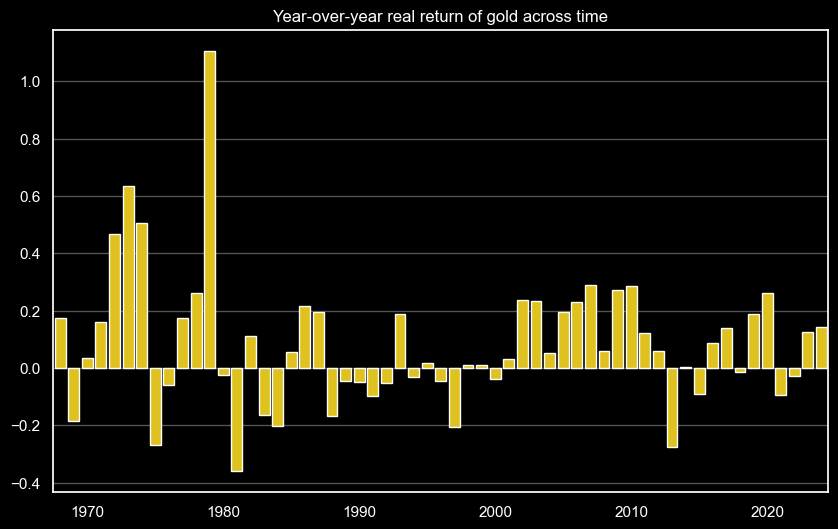

In [20]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df_au_yearly, x=df_au_yearly.index, y="real_price_change", color="gold")

plt.title("Year-over-year real return of gold across time")
plt.xlabel("")
plt.ylabel("")

# Show only beginning of decade
ax = plt.gca()
for index, label in enumerate(ax.get_xticklabels()):
    if index % 10 - 2 != 0:
        label.set_visible(False)

save_chart_as_png("3.1_AU_YoY_real_return")

In [21]:
# Average YoY real return
df_au_yearly["real_price_change"].mean().round(4)

0.0848

In [22]:
# Average YoY real return since 1980
df_au_yearly.loc[1980:]["real_price_change"].mean().round(4)

0.0407

In [23]:
# Average YoY real return since 2000
df_au_yearly.loc[2000:]["real_price_change"].mean().round(4)

0.099

In [24]:
# Median YoY real return
df_au_yearly["real_price_change"].median().round(4)

0.0567

In [25]:
# Standard deviation YoY real return
df_au_yearly["real_price_change"].std().round(4)

0.2355

In [26]:
# Cumulative product YoY real return
(1 + df_au_yearly["real_price_change"]).cumprod().iloc[-1].round(4) - 1

30.4258

In [27]:
# Get average, median, standard deviation and cumulative product YoY return per decade
df_au_yearly["decade"] = (df_au_yearly.index // 10) * 10
df_au_yearly.groupby("decade").agg(
    avg_yoy_price_change=("real_price_change", lambda x: x.mean().round(4)),
    median_yoy_price_change=("real_price_change", lambda x: x.median().round(4)),
    std_yoy_price_change=("real_price_change", lambda x: x.std().round(4)),
    cumprod_yoy_price_change=("real_price_change", lambda x: (1 + x).cumprod().iloc[-1].round(4) - 1),
    dod_price_change=("decade", lambda x: (df_au_yearly.loc[x.index, "last_price"].iloc[-1] - df_au_yearly.loc[x.index, "first_price"].iloc[0]) / df_au_yearly.loc[x.index, "first_price"].iloc[0])
).T

decade,1960,1970,1980,1990,2000,2010,2020
avg_yoy_price_change,-0.005000,0.301100,-0.038400,-0.02580,0.156000,0.050500,0.082100
median_yoy_price_change,-0.005000,0.217800,-0.035300,-0.03870,0.212100,0.073300,0.123900
std_yoy_price_change,0.253700,0.393300,0.186300,0.10000,0.117700,0.156700,0.142200
cumprod_yoy_price_change,-0.042200,8.261000,-0.434400,-0.26500,3.058900,0.465400,0.432700
dod_price_change,-0.071795,6.537207,-0.546207,-0.43796,2.137076,0.183067,0.306254


**Key takeaways:**
- Gold's average year-over-year real return is 8.5%, which is notably high.
- The median YoY real return for gold slightly surpasses the nominal return median.
- The average real return since the 1980s is 4%, increasing to 10% since the 2000s.
- Although the price chart suggests gold tracks inflation, the data indicates a significant positive return after accounting for inflation.

### STL decomposition (trend, seasonality, and residuals)

In [28]:
stl = STL(df_au["real_price"], period=252).fit()

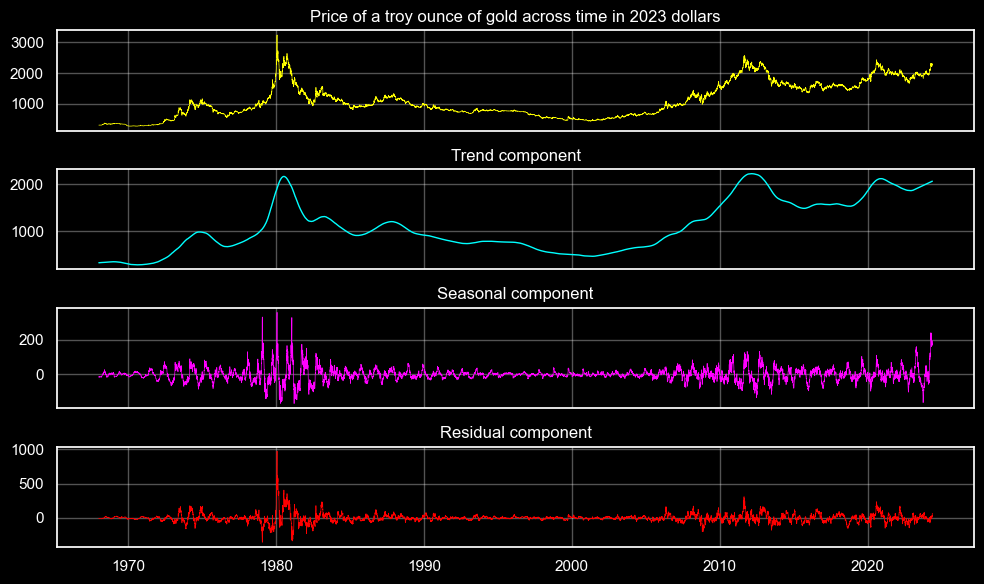

In [29]:
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].plot(df_au.index, df_au["real_price"], label="Original", color="yellow", linewidth=0.5)
axes[0].set_title("Price of a troy ounce of gold across time in 2023 dollars")

axes[1].plot(df_au.index, stl.trend, label="Trend", color="aqua", linewidth=1)
axes[1].set_title("Trend component")

axes[2].plot(df_au.index, stl.seasonal, label="Seasonal", color="fuchsia", linewidth=0.5)
axes[2].set_title("Seasonal component")

axes[3].plot(df_au.index, stl.resid, label="Residual", color="red", linewidth=0.5)
axes[3].set_title("Residual component")

plt.tight_layout()

#### Trend analysis

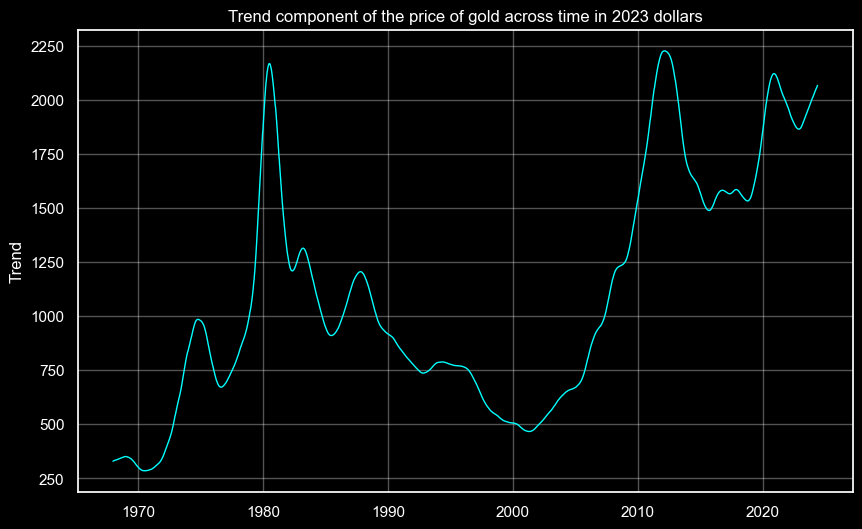

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(stl.trend, color="aqua", linewidth=1)

plt.title("Trend component of the price of gold across time in 2023 dollars")
plt.xlabel("")
plt.ylabel("Trend")

save_chart_as_png("3.1_AU_real_trend")

In [31]:
# Top 3 peaks
peaks, _ = signal.find_peaks(stl.trend, distance=800)
top_peaks = stl.trend.iloc[peaks].nlargest(3)
pd.DataFrame({"value": top_peaks}).T

date,2012-02-17,1980-07-08,2020-11-23
value,2226.498605,2167.637999,2121.041747


**The valleys in the trend are more pronounced, and the peak in 2012 is higher than the peak in 1980, despite ATH being on 1980.**

#### Seasonality analysis

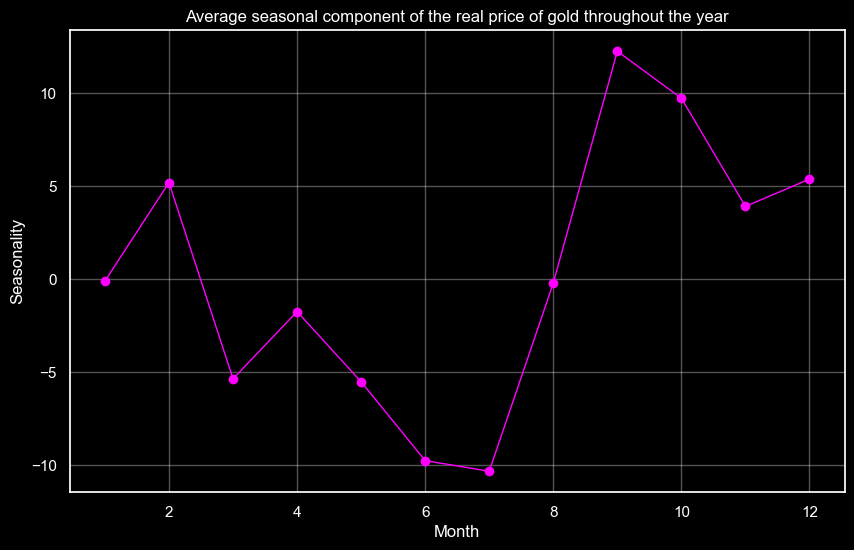

In [32]:
seasonal = stl.seasonal
monthly_avgs = seasonal.groupby(seasonal.index.month).mean()

plt.figure(figsize=(10, 6))

plt.plot(monthly_avgs.index, monthly_avgs.values, marker='o', color="fuchsia", linewidth=1)

plt.title("Average seasonal component of the real price of gold throughout the year")
plt.xlabel("Month")
plt.ylabel("Seasonality")

save_chart_as_png("3.1_AU_real_seasonal")

**When adjusting for inflation, the average seasonality aligns more closely with some analysts' descriptions.**

*No need to check anything related to volatility or short-term price analysis.*